In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [9]:
data_path = "C:\\Users\\LENOVO\\.jupyter\\Loyal Guru Project\\Customer Data\\data.csv.zip"
df = pd.read_csv(data_path, encoding='ISO-8859-1')

In [11]:
# Quick data overview
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [33]:
# Drop rows with missing CustomerID (hard to segment anonymous customers)
df = df.dropna(subset=['CustomerID'])

In [35]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [37]:
# Remove negative or zero quantity orders (usually returns or errors)
df = df[df['Quantity'] > 0]

In [39]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None


In [41]:
import datetime as dt

# Reference date: the day after the last purchase in data (to calculate recency)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics per customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency (unique invoices)
    'Quantity': 'sum',                                       # Total quantity bought
    'UnitPrice': 'mean'                                      # Avg price per item (optional)
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Quantity': 'Monetary'})

# Monetary could also be quantity * unit price sum per customer:
rfm['Monetary'] = df.groupby('CustomerID').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())

print(rfm.head())

            Recency  Frequency  Monetary  UnitPrice
CustomerID                                         
12346.0         326          1  77183.60   1.040000
12347.0           2          7   4310.00   2.644011
12348.0          75          4   1797.24   5.764839
12349.0          19          1   1757.55   8.289041
12350.0         310          1    334.40   3.841176


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3768\962841027.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rfm['Monetary'] = df.groupby('CustomerID').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame for convenience
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

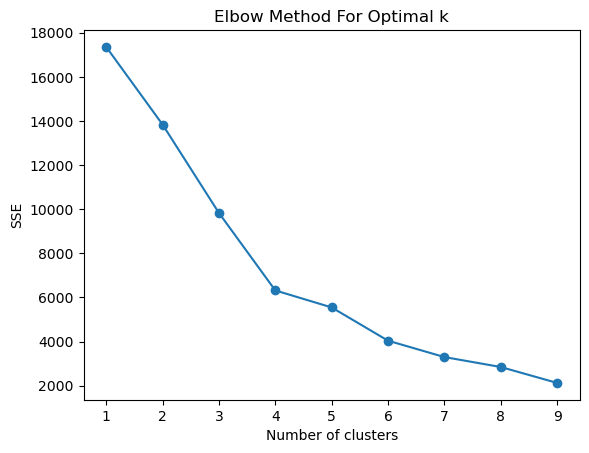

            Recency  Frequency  Monetary  UnitPrice  Segment
CustomerID                                                  
12346.0         326          1  77183.60   1.040000        1
12347.0           2          7   4310.00   2.644011        0
12348.0          75          4   1797.24   5.764839        0
12349.0          19          1   1757.55   8.289041        0
12350.0         310          1    334.40   3.841176        1


In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Find optimal k (optional) with elbow method
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

# Choose k (say 4 for example)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())

In [47]:
# Example assignment based on segments
campaign_map = {
    0: "Welcome bonus & referral program",
    1: "Exclusive rewards & early access",
    2: "Targeted discounts to increase purchase frequency",
    3: "Re-engagement offers for at-risk customers"
}

rfm['Campaign'] = rfm['Segment'].map(campaign_map)

print(rfm[['Recency', 'Frequency', 'Monetary', 'Segment', 'Campaign']].head())

            Recency  Frequency  Monetary  Segment  \
CustomerID                                          
12346.0         326          1  77183.60        1   
12347.0           2          7   4310.00        0   
12348.0          75          4   1797.24        0   
12349.0          19          1   1757.55        0   
12350.0         310          1    334.40        1   

                                    Campaign  
CustomerID                                    
12346.0     Exclusive rewards & early access  
12347.0     Welcome bonus & referral program  
12348.0     Welcome bonus & referral program  
12349.0     Welcome bonus & referral program  
12350.0     Exclusive rewards & early access  
